<a href="https://colab.research.google.com/github/phoumithona/reinforcement-learning-course-2022-1/blob/main/GPU_Allocator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab\n")
except:
    print("Note: not using Google CoLab\n")
    COLAB = False

if COLAB:
    !apt-get install xvfb ffmpeg x11-utils
    !pip install 'gym==0.17.3'
    !pip install 'imageio==2.4.0'
    !pip install PILLOW
    !pip install 'pyglet==1.5.0'
    !pip install pyvirtualdisplay
    !pip install 'tf-agents==0.12.0'
    !pip install transformers

Note: using Google CoLab

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

#Importing Packages

In [2]:
import math
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register

import base64
import imageio
import IPython
import PIL.Image
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont
import pyvirtualdisplay

# Set up a virtual display for rendering OpenAI gym environments.
vdisplay = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

from model_latency import *

vgg latency = 5.87


#Create a Custom Environment

In [3]:
class GPUallocatorEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    #-----States Definition-----#
    STATE_ELEMENTS = 6
    STATES = ['latency_vgg_19', 'latency_resnet_50', 'latency_alexnet', 'SLO_vgg_19', 'SLO_resnet_50', 'SLO_alexnet']                           
    STATE_LATENCY_VGG_19 = 0
    STATE_LATENCY_RESNET_50 = 1
    STATE_LATENCY_ALEXNET = 2
    STATE_SLO_VGG_19 = 3
    STATE_SLO_RESNET_50 = 4
    STATE_SLO_ALEXNET = 5

    #-----Actions Definition-----#
    ACTION_ELEMENTS = 3
    ACTION_VGG_19 = 0
    ACTION_RESNET_50 = 1
    ACTION_ALEXNET = 2

    def __init__(self):
        self.action_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(GPUallocatorEnv.ACTION_ELEMENTS,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=0,
            high=500,
            shape=(GPUallocatorEnv.STATE_ELEMENTS,),
            dtype=np.float32
        )

        self.seed()
        self.reset()
        self.state_log = []

    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #-----Evaluate Actions in (%)-----#
    def eval_action(self, action):
        act_vgg_19 = action[GPUallocatorEnv.ACTION_VGG_19]
        act_resnet_50 = action[GPUallocatorEnv.ACTION_RESNET_50]
        act_alexnet = action[GPUallocatorEnv.ACTION_ALEXNET]

        total_act = act_vgg_19 + act_resnet_50 + act_alexnet

        if total_act < 1e-2:
            pct_vgg_19 = 0
            pct_resnet_50 = 0
            pct_alexnet = 0
        else:
            pct_vgg_19 = act_vgg_19 / total_act
            pct_resnet_50 = act_resnet_50 / total_act
            pct_alexnet = act_alexnet / total_act

        return pct_vgg_19, pct_resnet_50, pct_alexnet

    #-----step function = accepts actions, then return as a tuple of (S, R, flag)-----#
    def step(self, action):
        self.last_action = action
    
        pct_vgg_19, pct_resnet_50, pct_alexnet = self.eval_action(action)
  
        get_latency = ModelLatency()

        self.state[GPUallocatorEnv.STATE_LATENCY_VGG_19] = get_latency.vgg_19_latency(int(100 * pct_vgg_19))
        self.state[GPUallocatorEnv.STATE_LATENCY_RESNET_50] = get_latency.resnet_50_latency(int(100 * pct_resnet_50))      
        self.state[GPUallocatorEnv.STATE_LATENCY_ALEXNET] = get_latency.alexnet_latency(int(100 * pct_alexnet))
        
        latency_vgg_19 = self.state[GPUallocatorEnv.STATE_LATENCY_VGG_19]
        latency_resnet_50 = self.state[GPUallocatorEnv.STATE_LATENCY_RESNET_50]
        latency_alexnet = self.state[GPUallocatorEnv.STATE_LATENCY_ALEXNET]
      
        SLO_vgg_19 = self.state[GPUallocatorEnv.STATE_SLO_VGG_19]
        SLO_resnet_50 = self.state[GPUallocatorEnv.STATE_SLO_RESNET_50]
        SLO_alexnet = self.state[GPUallocatorEnv.STATE_SLO_ALEXNET]
      
        reward_vgg_19 = SLO_vgg_19 - latency_vgg_19
        reward_resnet_50 = SLO_resnet_50 - latency_resnet_50
        reward_alexnet = SLO_alexnet - latency_alexnet
        reward = reward_vgg_19 + reward_resnet_50 + reward_alexnet
        
        done = (100*reward_vgg_19)/SLO_vgg_19 < 5 or (100*reward_resnet_50)/SLO_resnet_50 < 5 or (100*reward_alexnet)/SLO_alexnet < 5

        self.state_log.append(self.state)
        self.step_num += 1

        return self.state, reward, done, {}

    #-----Reset Function: performs one step of simulation, and returns initial state space-----#
    def reset(self):
        self.step_num = 0
        self.last_action = [0] * GPUallocatorEnv.ACTION_ELEMENTS
        self.state = [0] * GPUallocatorEnv.STATE_ELEMENTS
        self.state_log = []
        # In the paper SLO = 50ms
        self.state[GPUallocatorEnv.STATE_LATENCY_VGG_19] = 56
        self.state[GPUallocatorEnv.STATE_LATENCY_RESNET_50] = 22
        self.state[GPUallocatorEnv.STATE_LATENCY_ALEXNET] = 6
        self.state[GPUallocatorEnv.STATE_SLO_VGG_19] = 25
        self.state[GPUallocatorEnv.STATE_SLO_RESNET_50] = 25
        self.state[GPUallocatorEnv.STATE_SLO_ALEXNET] = 25
            
        return np.array(self.state)
        
    #-----Render Function: renders one frame of the simulation-----#
    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)

        #-----Render State Values-----#
        state_latency_vgg_19 = self.state[GPUallocatorEnv.STATE_LATENCY_VGG_19]
        state_latency_resnet_50 = self.state[GPUallocatorEnv.STATE_LATENCY_RESNET_50]
        state_latency_alexnet = self.state[GPUallocatorEnv.STATE_LATENCY_ALEXNET]
        slo_vgg_19 = self.state[GPUallocatorEnv.STATE_SLO_VGG_19]
        slo_resnet_50 = self.state[GPUallocatorEnv.STATE_SLO_RESNET_50]
        slo_alexnet = self.state[GPUallocatorEnv.STATE_SLO_ALEXNET]

        d.text((0, y), f"vgg-19 latency: {state_latency_vgg_19:,}", fill=(0, 255, 0))
        y += height
        d.text((0, y), f"resnet-50 latency: {state_latency_resnet_50:,}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"alexnet latency: {state_latency_alexnet:,}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"SLO vgg-19: {slo_vgg_19:,}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"SLO resnet-50: {slo_resnet_50:,}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"SLO alexnet: {slo_alexnet:,}",fill=(0, 255, 0))
        y += height

        #-----Render GPU Percentages-----#
        pct_vgg_19, pct_resnet_50, pct_alexnet = self.eval_action(self.last_action)
        d.text((0, y), f"vgg-19 GPU%: {int(100 * pct_vgg_19)}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"resnet-50 GPU%: {int(100 * pct_resnet_50)}",fill=(0, 255, 0))
        y += height
        d.text((0, y), f"alexnet GPU%: {int(100 * pct_alexnet)}", fill=(0, 255, 0))
        y += height

        return np.array(img)

#-----Register the environment class with TF-Agents-----#
register(
    id='GPU-allocator-RL-teamPJT-v0',
    entry_point=f'{__name__}:GPUallocatorEnv',
)

#Hyperparameters

In [4]:
num_iterations = 1000  # How long should training run?

log_interval = 100    # How often should the program provide an update.

initial_collect_steps = 1000    # How many initial random steps, before training start, to collect initial data.

collect_steps_per_iteration = 50    # How many steps should we run each iteration to collect data from.

replay_buffer_max_length = 100000   # How much data should we store for training example.

batch_size = 64   # Inclease the batch size --> increase the latency

num_eval_episodes = 100   # How many episodes should the program use for each evaluation.

eval_interval = 10    # How often should an evaluation occur.

#Instantiate the Environment

In [5]:
env_name = 'GPU-allocator-RL-teamPJT-v0'
env = suite_gym.load(env_name)

env.reset()
done = False

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#DDPG: Actor Critic Model

In [6]:
actor_fc_layers = (400, 300)
critic_obs_fc_layers = (400,)
critic_action_fc_layers = None
critic_joint_fc_layers = (300,)
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.995
reward_scale_factor = 0.9
gradient_clipping = None

actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
debug_summaries = False
summarize_grads_and_vars = False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actor_network.ActorNetwork(
    train_env.time_step_spec().observation,
    train_env.action_spec(),
    fc_layer_params=actor_fc_layers,
)

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)
#-----Agent-----#
tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

#Metrics and Evaluation

In [7]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0

    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

#Data Collection

In [8]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), 
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


#Training the Agent

In [9]:
iterator = iter(dataset)

tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]
loss_log = []

for _ in range(num_iterations):
    
    # Collect a few steps and save to the replay buffer
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, tf_agent.collect_policy, replay_buffer)
        
    # sample a batch of data from the buffer and update the agent's network
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience).loss

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        loss_log.append(train_loss)

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 10: Average Return = 0.8000001311302185
step = 20: Average Return = -11.369996070861816
step = 30: Average Return = -20.010007858276367
step = 40: Average Return = -44.31004333496094
step = 50: Average Return = -51.0400276184082
step = 60: Average Return = -51.0400276184082
step = 70: Average Return = -51.0400276184082
step = 80: Average Return = -34.760005950927734
step = 90: Average Return = 4.320005416870117
step = 100: loss = 174.78846740722656
step = 100: Average Return = 4.399995803833008
step = 110: Average Return = 10.099989891052246
step = 120: Average Return = 14.92000961303711
step = 130: Average Return = 14.92000961303711
step = 140: Average Return = 14.92000961303711
step = 150: Average Return = 14.92000961303711
step = 160: Average Return = 14.92000961303711
step = 170: Average Return = 14.92000961303711
step = 180: Average Return = 14.92000961303711
step = 190: Average Return = 14.92000961303711
step = 200: loss = 229.7786102294922
step = 200: Average Return = 14.

#Visualization

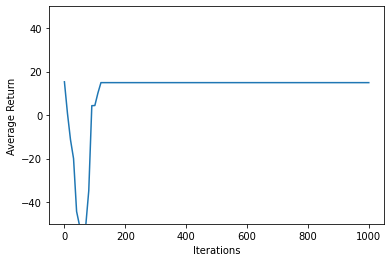

In [10]:
iterations = range(0,  num_iterations + 1, eval_interval)
plt.xlabel('Iterations')
plt.ylabel('Average Return')
plt.ylim(-50, 50)
plt.plot(iterations, returns)
plt.show()

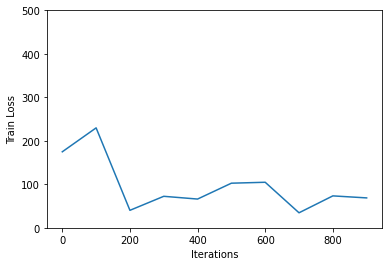

In [11]:
iterations_loss = range(0, num_iterations, log_interval)
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.ylim(0, 500)
plt.plot(iterations_loss, loss_log)
plt.show()

In [12]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=200, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


create_policy_eval_video(tf_agent.policy, "trained-agent")